In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My\ Drive/rubik_project

/content/gdrive/My Drive/rubik_project


In [3]:
!nvidia-smi

Sun Jan 19 05:42:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 1.x 
import tensorflow as tf 
import os
import numpy as np
import cv2
from PIL import Image
import imutils
import model

In [5]:
os.listdir()

['data',
 'face_detector',
 '__pycache__',
 'checkpoints',
 'data_utils.py',
 'face_multitask.jpg',
 'config.py',
 'data_provider.py',
 'model.py',
 'bknet_4braches.ipynb',
 'test.ipynb',
 'face.jpg',
 'image_demo.ipynb',
 'new_face.jpg']

/content/gdrive/My Drive/rubik_project/face.jpg


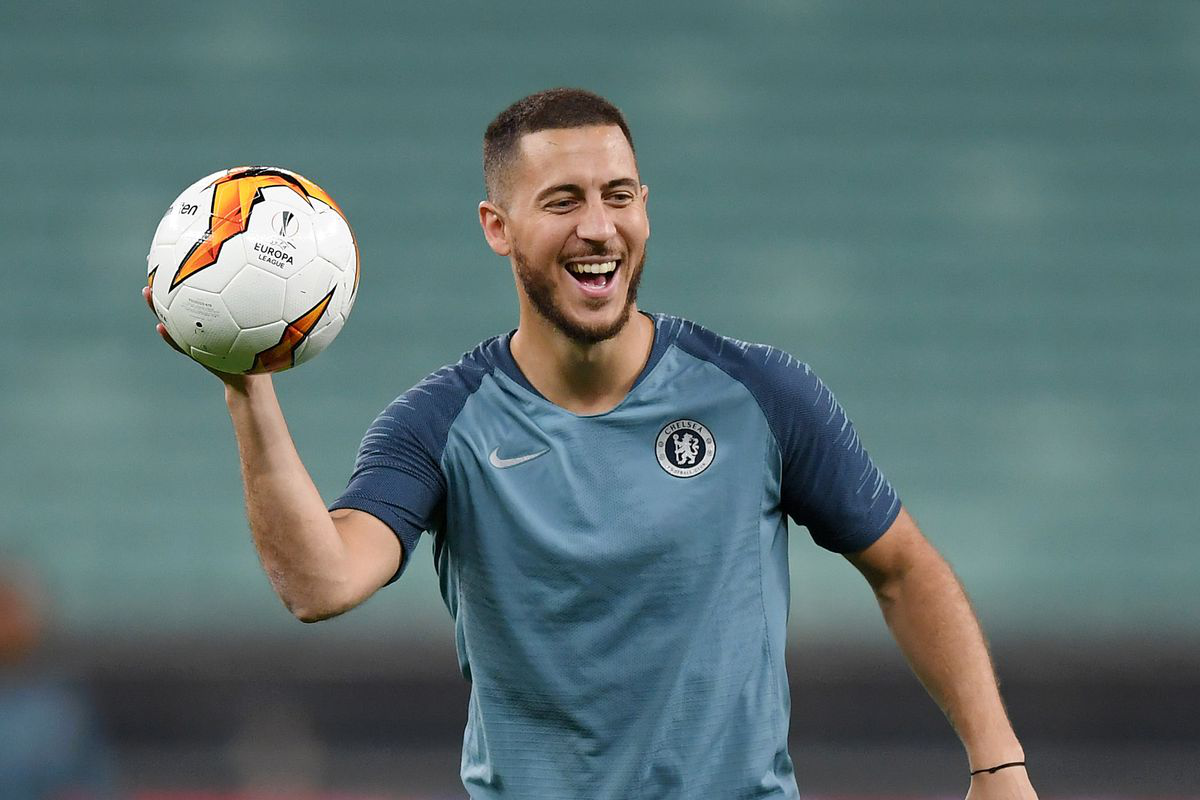

In [7]:
image_path = os.path.join(os.getcwd(), 'face.jpg')
print(image_path)
Image.open(image_path)

In [8]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
sess = tf.InteractiveSession()

In [10]:
test_model = model.Multitask_BKNet(sess)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

(?, 24, 24, 32)
(?, 12, 12, 64)
(?, 6, 6, 128)
(?, 3, 3, 256)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Load smile image...................
Done !
Number of smile train data:  3000
---------------------------------------------------------------
Load emotion image..................
Done !
Number of emotion train data:  28709
---------------------------------------------------------------
Load gender image...................
Done !
Number of gender train data:  30000
---------------------------------------------------------------
Load age image..................
Done !
Number of age train data:  27353
---------------------------------------------------------------

Instructions for updating:
Please use tf.global_variables instead.
Reading model parameters from %s /content/gdrive/My Drive/rubik_project/checkpoints/17

In [0]:
SMILE_INDEX = {0: 'Not Smile', 1: 'Smile'}
EMOTION_INDEX = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
GENDER_INDEX = {0: 'Female', 1: 'Male'}
AGE_INDEX = {0: '1-10', 1: '11-20', 2: '21-30', 3: '31-40', 4: '41-50', 5: '51-60', 6: '61-70'}

In [17]:
DETECTOR_FOLDER = os.path.join(os.getcwd(), 'face_detector')
prototxt = os.path.join(DETECTOR_FOLDER, 'deploy.prototxt.txt')
face_model = os.path.join(DETECTOR_FOLDER, 'res10_300x300_ssd_iter_140000.caffemodel')

DEFAULT_CONFIDENCE = 0.3

print("[INFO] loading face detector...")
net = cv2.dnn.readNetFromCaffe(prototxt, face_model)
print("Done")

[INFO] loading face detector...
Done


[INFO] loading face detector...
Done


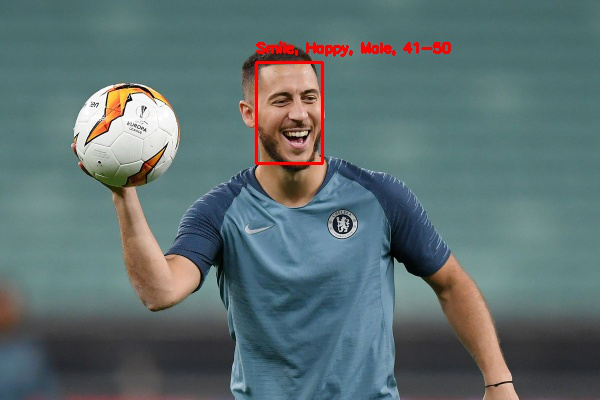

In [16]:
# load face detector model
DETECTOR_FOLDER = os.path.join(os.getcwd(), 'face_detector')
prototxt = os.path.join(DETECTOR_FOLDER, 'deploy.prototxt.txt')
face_model = os.path.join(DETECTOR_FOLDER, 'res10_300x300_ssd_iter_140000.caffemodel')

DEFAULT_CONFIDENCE = 0.3

print("[INFO] loading face detector...")
net = cv2.dnn.readNetFromCaffe(prototxt, face_model)
print("Done")

image = cv2.imread(image_path)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), 
                                  (104.0, 177.0, 123.0), swapRB=False, crop=False)

net.setInput(imageBlob)
detections = net.forward()

# loop over the detections 
for i in range(0, detections.shape[2]):
  confidence = detections[0, 0, i, 2]

  if confidence > DEFAULT_CONFIDENCE:
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # extract face ROI
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(face, (48, 48))
    face = (face-128.0) / 255
    T = np.zeros([48, 48, 1])
    T[:, :, 0] = face
    test_img = []
    test_img.append(T)
    test_img = np.asarray(test_img)

    feed_dict = {test_model.input_images: test_img, test_model.phase_train: False, test_model.keep_prob: 1}
    predict_y_smile_conv = np.argmax(sess.run(test_model.y_smile_conv, feed_dict=feed_dict))
    predict_y_emotion_conv = np.argmax(sess.run(test_model.y_emotion_conv, feed_dict=feed_dict))
    predict_y_gender_conv = np.argmax(sess.run(test_model.y_gender_conv, feed_dict=feed_dict))
    predict_y_age_conv = np.argmax(sess.run(test_model.y_age_conv, feed_dict=feed_dict))

    smile_label = SMILE_INDEX[predict_y_smile_conv]
    emotion_label = EMOTION_INDEX[predict_y_emotion_conv]
    gender_label = GENDER_INDEX[predict_y_gender_conv]
    age_label = AGE_INDEX[predict_y_age_conv]

    text = "{}, {}, {}, {}".format(smile_label, emotion_label, gender_label, age_label)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(image, text, (startX, y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

new_image_path = os.path.join(os.getcwd(), 'new_face.jpg')
cv2.imwrite(new_image_path, image)
Image.open(new_image_path)

In [0]:
def demo_image(image_name):
  image_path = os.path.join(os.getcwd(), image_name)
  image = cv2.imread(image_path)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), 
                                    (104.0, 177.0, 123.0), swapRB=False, crop=False)

  net.setInput(imageBlob)
  detections = net.forward()

  # loop over the detections 
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > DEFAULT_CONFIDENCE:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

      # extract face ROI
      face = image[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
      face = cv2.resize(face, (48, 48))
      face = (face-128.0) / 255
      T = np.zeros([48, 48, 1])
      T[:, :, 0] = face
      test_img = []
      test_img.append(T)
      test_img = np.asarray(test_img)

      feed_dict = {test_model.input_images: test_img, test_model.phase_train: False, test_model.keep_prob: 1}
      predict_y_smile_conv = np.argmax(sess.run(test_model.y_smile_conv, feed_dict=feed_dict))
      predict_y_emotion_conv = np.argmax(sess.run(test_model.y_emotion_conv, feed_dict=feed_dict))
      predict_y_gender_conv = np.argmax(sess.run(test_model.y_gender_conv, feed_dict=feed_dict))
      predict_y_age_conv = np.argmax(sess.run(test_model.y_age_conv, feed_dict=feed_dict))

      smile_label = SMILE_INDEX[predict_y_smile_conv]
      emotion_label = EMOTION_INDEX[predict_y_emotion_conv]
      gender_label = GENDER_INDEX[predict_y_gender_conv]
      age_label = AGE_INDEX[predict_y_age_conv]

      text = "{}, {}, {}, {}".format(smile_label, emotion_label, gender_label, age_label)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
      cv2.putText(image, text, (startX, y), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  
    new_image_path = os.path.join(os.getcwd(), 'new_' + image_name + '.jpg')
    cv2.imwrite(new_image_path, image)
    Image.open(new_image_path)

In [0]:
demo_image('5people.jpeg')